In [43]:
!pip install imageio

zsh:1: no matches found: imageio[ffmpeg]


In [24]:
import imageio

In [2]:
import czifile
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import time

In [3]:
fname = "500kStellateAstros_NucelofectionBacMam24hrs_Cal590-12_MIP.czi"

In [15]:
data = czifile.imread(fname).squeeze()

In [9]:
data.shape

(224, 2, 2048, 1124)

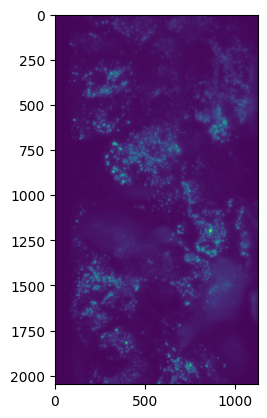

In [26]:
plt.imshow(data[10][0])

In [90]:
data.dtype

dtype('uint16')

## Dataloader

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [52]:
class CziVideoDataset(Dataset):
    def __init__(self, fpath, frame_split=[16,16], channel=0):
        data = czifile.imread(fpath).squeeze()
        self.patches_per_frame = frame_split[0] * frame_split[1]
        self.grid_size = frame_split
        self.frames = data[:,channel, :, :].astype(np.float32)
        self.frame_tensors = torch.tensor(self.frames, dtype=torch.float32).clone().detach()
    
    def __len__(self):
        return(len(self.frames) * self.patches_per_frame)

    def __getitem__(self, idx):
        print(f"frame {int(idx/self.patches_per_frame)}, patch {idx%self.patches_per_frame}") 
        patch = self.get_patch(int(idx/self.patches_per_frame), idx%self.patches_per_frame)
        return(torch.flatten(patch))

    def get_patch(self, frame_index, patch):
        arr = self.frame_tensors[frame_index]
        assert patch < self.patches_per_frame, "Patch index out of range"
        height, width = arr.shape
        #print(height, width)
        row_size, col_size = int(height / self.grid_size[0]), int(width/self.grid_size[1])
        patch_row, patch_col = int(patch/self.grid_size[1]), patch%self.grid_size[1] # [0 1 2; 3 4 5; 6 7 8]
        #print(f"Row {patch_row}, ({row_size}px), Col {patch_col}, ({col_size}px)")
        return(arr[row_size*patch_row:row_size*(patch_row+1), col_size*patch_col:col_size*(patch_col+1)])

    def save_as_video(self, output_path):
        s = time.time()
        # Define the video codec and frames per second (fps)
        height, width = self.frames[0].shape
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        fps = 30
        # Create a VideoWriter object
        video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=False)
        for frame in self.frames:
            video_writer.write(frame)
        video_writer.release()
        
        print(f"Video saved to: {output_path} in {time.time() - s} seconds")

    def save2(self, fname):
        fps = 30
        # Write frames to the video file
        with imageio.get_writer(fname, fps=fps) as writer:
            for frame in self.frames:
                writer.append_data(frame)
        print(f"Video saved to: {fname} in {time.time() - s} seconds")
        


In [53]:
%%time
ds = CziVideoDataset(fname, [16, 4])

CPU times: user 1.47 s, sys: 7.32 s, total: 8.79 s
Wall time: 4.76 s


In [60]:
ds.frames.shape

(224, 2048, 1124)

In [54]:
dataloader = DataLoader(ds, batch_size=16, shuffle=True)

In [56]:
ds[10].shape

frame 0, patch 10


torch.Size([35968])

In [57]:
x = next(iter(dataloader))

frame 222, patch 18
frame 15, patch 30
frame 185, patch 28
frame 5, patch 54
frame 140, patch 54
frame 21, patch 42
frame 65, patch 23
frame 107, patch 8
frame 166, patch 53
frame 23, patch 13
frame 82, patch 39
frame 175, patch 34
frame 37, patch 1
frame 66, patch 37
frame 108, patch 49
frame 146, patch 32


In [58]:
x.shape

torch.Size([16, 35968])

In [17]:
%%time
ds[100]

frame 1, patch 36
CPU times: user 979 µs, sys: 3.29 ms, total: 4.27 ms
Wall time: 4.89 ms


tensor([[105., 109., 105.,  ..., 249., 235., 249.],
        [105., 107., 100.,  ..., 272., 253., 248.],
        [ 97., 107., 109.,  ..., 230., 257., 246.],
        ...,
        [ 97., 108., 108.,  ..., 254., 264., 264.],
        [100., 101., 102.,  ..., 252., 275., 276.],
        [102., 103., 112.,  ..., 266., 234., 242.]])

In [35]:
ds.frames.shape

(224, 2048, 1124)

In [41]:
fpath = "test.mp4"
fps = 30
with imageio.get_writer(fpath) as writer:
    writer.fps = fps  # Set the frame rate
    for frame in ds.frames:
        writer.append_data(frame)
    

In [46]:
# Define the output video file path
output_video_path = 'yeetud.mov'

# Define the frames per second (fps)
fps = 30
s=time.time()
# Write frames to the video file
with imageio.get_writer(output_video_path, mode='I') as writer:
    writer.fps = fps
    for frame in ds.frames:
        writer.append_data(frame)

print(f"Video saved to: {output_video_path} in {time.time() - s} seconds")

Video saved to: yeetud.mov in 0.5580589771270752 seconds
